# Decision trees in machine learning

## Try me
 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ffraile/operations-research-notebooks/blob/main/docs/source/Decision%20Theory/tutorials/Decision_trees_in_machine_learning.ipynb)[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ffraile/operations-research-notebooks/main?labpath=docs%2Fsource%2FDecision%20Theory%2Ftutorials%2FDecision_trees_in_machine_learning.ipynb)

## Introduction
So far, we have seen how decision trees can be used as tools to support decision making in complex decisional problems. However, decision trees provide the basis for a family of machine learning techniques. The idea behind these techniques is to learn from training data a decision tree that can be used to solve a machine learning tasks. Normally, decision trees are applied in **classification problems** (recall that these problems the objective is to classify input data into known categories based on the features available in the training data). 

The objective is to generate a decision tree which represents the decisions that the machine will take to classify a data sample based on its features. For instance, let´s generate some synthetic data representing sensor data from two sensors, temperature and encoding speed, in two different operating states, normal operation and failure. The following script generates some synthetic data that we can use to guide the example:

Text(0.5, 1.0, 'Sensor readings')

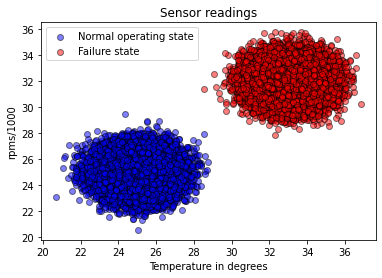

In [ ]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

n_samples = 50000
centers = [(25, 25), (33, 32)]
X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)
plt.figure()
y_unique = np.unique(y)
colors = ['blue', 'red']
classes = ['Normal operating state', 'Failure state']
for this_y, color in zip(y_unique, colors):
    this_X = X[y == this_y]
    
    plt.scatter(
        this_X[:, 0],
        this_X[:, 1],
        c=color,
        alpha=0.5,
        edgecolor="k",
        label=classes[this_y],
    )
plt.legend(loc="best")
plt.ylabel('rpms/1000')
plt.xlabel('Temperature in degrees')
plt.title("Sensor readings")

Analyzing the data, we can see that the machine is in normal operating state if the rpms are below 29000 rpms and the temperature below 29 degrees celsius. 
The decision tree below shows how these decisions perform the classification.

![condition monitoring decision tree](img/ml_decision_tree-condition-monitoring.drawio.png)

As you can see in the figure, we first check the temperature reading and compare it to a threshold value, and it will take one decision branch or the other depending on whether the reading is greater or equal to the threshold. Then, in a subsequente decision node, it will check the readings of the encoder and depending on the value, and the branch, determine if the machine is in normal operating state or in failure state. 


The script below represents the data and the resulting decision regions: 


Text(0.5, 1.0, 'Sensor readings')

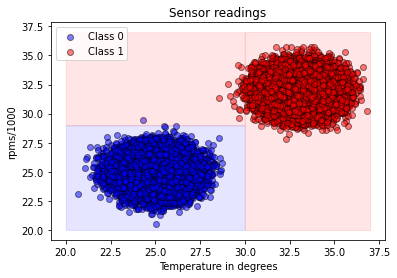

In [ ]:
plt.figure()

for this_y, color in zip(y_unique, colors):
    this_X = X[y == this_y]
    
    plt.scatter(
        this_X[:, 0],
        this_X[:, 1],
        c=color,
        alpha=0.5,
        edgecolor="k",
        label="Class %s" % this_y,
    )

x = np.linspace(20, 37, 1000)
sep1 = 0*x + 29
sep2 = 0*x + 20
plt.fill_between(x, sep1, sep2, where=x<=30, alpha=0.1, color=colors[0])
sep3 = 0*x + 37
plt.fill_between(x, sep3, sep1, where=x<=30, alpha=0.1, color=colors[1])
plt.fill_between(x, sep3, sep2, where=x>30, alpha=0.1, color=colors[1])
plt.legend(loc="best")
plt.ylabel('rpms/1000')
plt.xlabel('Temperature in degrees')
plt.title("Sensor readings")

Now, the objective is to develop an algorithm that is able to learn this decision tree from training data, that is, use the training data to decide which decision nodes are needed at each stage and what are the values of the thresholds that need to be applied. The result is a decision tree that can be used to classify new data, with the following generic structure:

![ml decision tree](img/ml_decision_tree.png)

The following section describes the most common strategy used in decision trees algorithms to obtain these decision trees.

## Decision Tree Learning Algorithms
### Strategy: Recursive Binary Splitting
The most common strategy used to build decision trees from training data consists in applying a **greedy approach** to split the dataset into subsets, step by step, choosing at every step the feature that *best splits* the data into two subsets, until each subset contains only data samples from one class, or until the subsets are *homogeneous* or *pure* enough, or in other words, the level of **entropy** of the data is low enough.
Moreover, the strategy is to iteratively select one feature to split the data until:
- All (or almost all) data samples in a leaf node belong to the same class (minimum impurity or minimum entropy).
- The tree has reached the maximum pre-defined number of splits (maximum depth).
- The tree has tried all features and found that none of them is useful to split the data anymore.

There are some concepts in the paragraph above that we need to unpack, mainly related to the concepts of data homogeneity and entropy.

#### Data Homogeneity
Data homogeneity is the condition that all data samples in a leaf node belong to the same class. The **Gini** impurity measure is a measure of data homogeneity in a dataset $S$), expressed as:

$\text{Gini}(S) = 1 - \sum_{i=1}^c{p_i^2}$

Where $C={1, 2, ..., c}$ is the set of possible classes, and $p_i$ is the probability of class $i$, defined as the number of data samples of class $i$ divided by the total number of data samples in the dataset. From the definition above, we can see that the impurity is 0 if all the data samples in the dataset are of the same class.

#### Entropy
In information theory, the entropy is a measure of the level of uncertainty in a system. Formally, the entropy of a system is the sum of the probability of each possible state of the system multiplied by the logarithm of the probability of each possible state of the system:

$\text{Entropy}(S) = \sum_{i=1}^c p_i \log_2 p_i$

To understand this measure, consider tossing a coin. If the coin is fair, the probability of getting heads is equal to the probability of getting tails, and the entropy of the system is 1, representing total disorder, or chaos, because the uncertainty of the result of the toss is maximum. However, if the coin is completely biased, for instance, the probability of getting heads is 1, then the entropy is 0, because the result is certain, and completely predictable.

We can see that the measure of entropy and the measure of impurity are equivalent, in the sense that we can use the entropy to assess data homogenity in a data subset.

#### Recursive partitioning
As mentioned above, the tree is built by partitioning the dataset into two subsets, selecting in each iteration the feature and the threshold that maximizes data homogenity (minimizes entropy or impurity). The partition is **recursive** because it is applied to every node of the tree (that is, the first partition results into two subsets, and then the partition is applied again to each subset, resulting in four subsets, and so forth).

At every iteration, the data at any node $m$ is partitioned into two datasets, and the data Homogeneity of the two datasets is evaluated for every candidate split $\theta$, expressed as two decision variables, the feature $j$ and a threshold $t_m$: $\theta = (j, t_m)$. Then, for instance, gradient descent methods can be used to find the optimal $\theta$ for the current node $m$ that minimizes the data Homogeneity.

Formally, let the data subset at node $m$ be $S_m$, consisting of $N_m$ data samples, each containing a feature vector $x$ and a label $y$. The candidate $\theta = (j, t_m)$ partition the data into two subsets $S_m^{left}(\theta)$ and $S_m^{right}(\theta)$, such that:

    $S_m^{left}(\theta) = \{x \in S_m : x_j \leq t_m\}$

    $S_m^{right}(\theta) = \{x \in S_m : x_j > t_m\}$

Let us now define the loss function for the current node $m$:

    $\text{L}(S_m,\theta) = \frac{N_m^{left}}{N_m}\text{H}(S_m^{left}(\theta)) + \frac{N_m^{right}}{N_m}\text{H}(S_m^{right}(\theta))$

where $N_m^{left}$ and $N_m^{right}$ are the number of data samples in the left and right subsets, respectively, and $\text{H}(S)$ is a measure of the data entropy or impurity in the dataset $S$.

This way, the learning problem is reduced to a minimization of the loss function, which is equivalent to finding the $\theta$ that minimizes the data Homogeneity.

##### Information gain
Another approach is to maximise the information gain, which is the difference between the data Homogeneity of the data subset at node $m$ and the data homogeinty of the two resulting subsets.

$\text{I}(S_m) = \text{H}(S_m)-\frac{N_m^{left}}{N_m}\text{H}(S_m^{left}) - \frac{N_m^{right}}{N_m}\text{H}(S_m^{right})$

That is, the objective now is to find the $\theta$ that maximizes the difference between the data homogeneity before and after the split.

#### Algorithms
There are different algorithms that use this approach to build decision trees, the most popular being Iterative Dichotomiser 3 (ID3), its successors C4.5 and C5.0., and finally the Classification and Regression Trees (CART) algorithm.

ID3 uses the greedy recursive partitioning algorithm finding for each node the feature and threshold that maximizes the information gain, with the limitation that the features must be categorical or qualitative (that is, it can only take one of a finite number of values). C4.5 and C5.0 on the other hand remove this restriction. CART is very similar to C4.5, but it provides additional support to solve regression problems.

#### Pruning
All the algorithm above have a common drawback: They tend to overfit the training data. To overcome this, they use a pruning strategy that removes the nodes that do not improve the model performance. One common pruning strategy is cost complexity pruning, where the nodes are removed (pruned) if they do not improve the model performance. Minimum cost complexity pruning finds the best trade-off between the tree complexity (expressed as the number of terminal nodes) and performance.


